## Setup

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import wfdb
import pywt
import padasip as pa
from scipy import signal

PATH = "ptbxl/"

%matplotlib inline
# %matplotlib notebook
plt.style.use("seaborn-paper")

In [2]:
metadata = pd.read_csv(PATH + "ptbxl_database.csv", index_col="ecg_id", dtype={
    'patient_id': np.int32,
})

r1 = wfdb.rdrecord(PATH + metadata.iloc[200]["filename_hr"])
lead_x = r1.p_signal[:, 1]
fs = 500.0  # sampling frequency (Hz)

## Band-pass Filter

Text(0, 0.5, 'Amplitude (mV)')

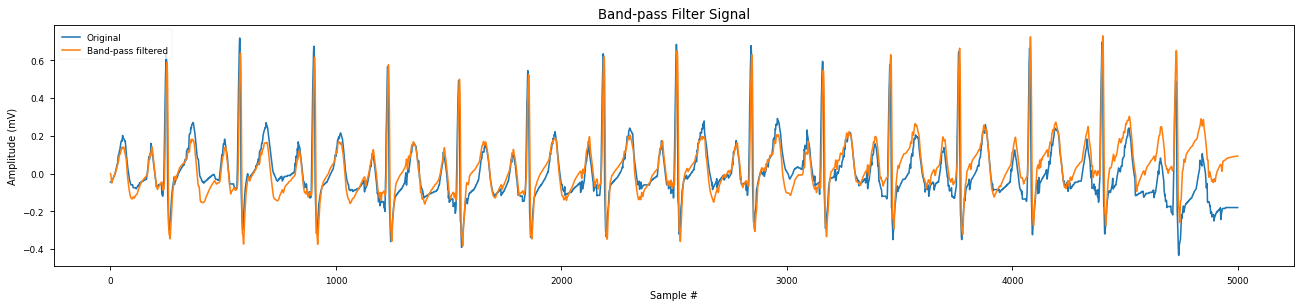

In [3]:
b2, a2 = signal.butter(
    6,  # order, currently arbitrarily chosen
    [0.4, 80],
    fs=fs, 
    btype='band', 
    analog=False
)

f2 = signal.lfilter(b2, a2, lead_x)

plt.figure(figsize=(20, 4), dpi=80)
plt.plot(lead_x, label="Original")
plt.plot(f2, label="Band-pass filtered")
plt.legend(loc="upper left")

plt.title("Band-pass Filter Signal", fontsize='large')
plt.xlabel('Sample #')
plt.ylabel('Amplitude (mV)')

Text(0, 0.5, 'Power')

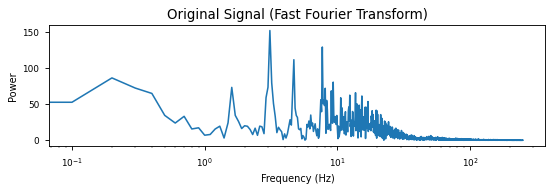

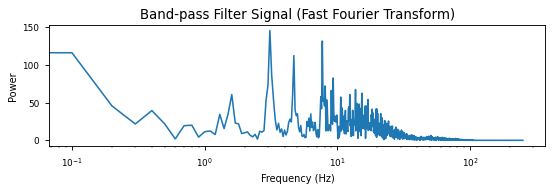

In [4]:
from scipy.fft import rfft, rfftfreq

N = int(len(lead_x))
yf = rfft(lead_x)
xf = rfftfreq(N, 1 / fs)

plt.figure(figsize=(8, 2), dpi=80)
plt.xscale("log")
plt.plot(xf, np.abs(yf))

plt.title("Original Signal (Fast Fourier Transform)", fontsize='large')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')

yf = rfft(f2)
xf = rfftfreq(N, 1 / fs)

plt.figure(figsize=(8, 2), dpi=80)
plt.xscale("log")
plt.plot(xf, np.abs(yf))

plt.title("Band-pass Filter Signal (Fast Fourier Transform)", fontsize='large')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')

## PLI Removal (notch filter)

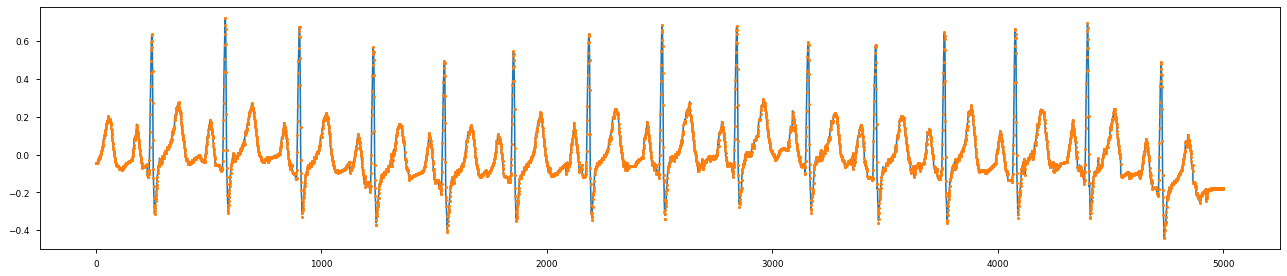

In [5]:
b1, a1 = signal.iirnotch(
    50.0,  # utility frequency to remove (Hz)
    25.0,  # quality factor
    fs=fs
)

f1 = signal.lfilter(b1, a1, lead_x)

plt.figure(figsize=(20, 4), dpi=80)
plt.plot(lead_x, label="Original")
plt.plot(f1, ".", label="PLI removed")

## Subtracting the Mean

Mean is -0.0018379999999999974


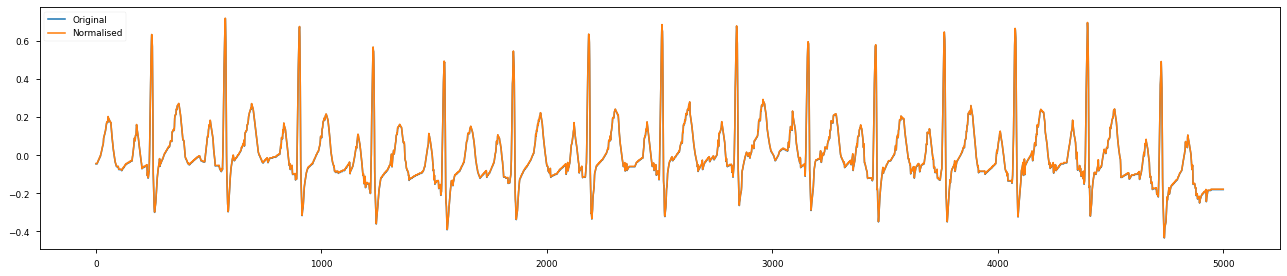

In [6]:
lead_mean = lead_x.mean()
normalised = [ (i - lead_mean) for i in lead_x ] 

print("Mean is", lead_mean)

plt.figure(figsize=(20, 4), dpi=80)
plt.plot(lead_x, label="Original")
plt.plot(normalised, label="Normalised")
plt.legend(loc="upper left")

## Discrete Wavelet Transformation

Text(0, 0.5, 'Amplitude (mV)')

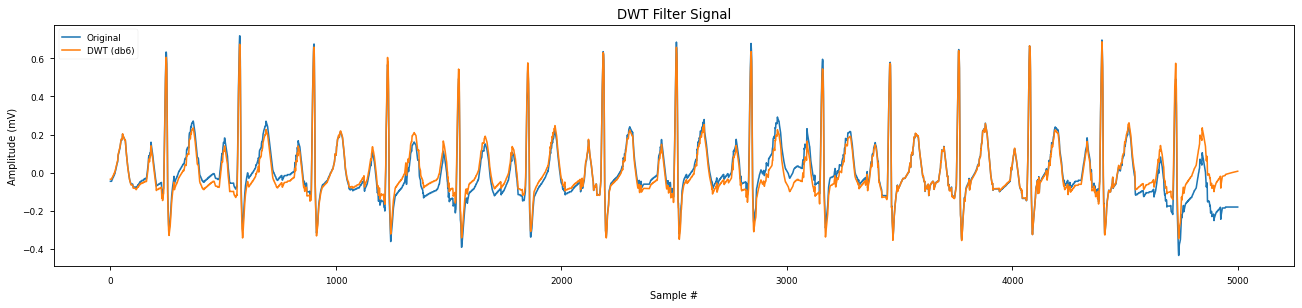

In [7]:
wvlt = 'db6'

max_level = pywt.dwt_max_level(data_len=len(lead_x), filter_len=pywt.Wavelet(wvlt).dec_len)  # max useful decomposition level

coeffs = pywt.wavedec(
    lead_x,
    wvlt,
    level=max_level
)

coeffs[0] = np.zeros(len(coeffs[0]))

# Inverse DWT (multilevel reconstruction)
idwt = pywt.waverec(
    coeffs,
    wvlt,
)

plt.figure(figsize=(20, 4), dpi=80)
plt.plot(lead_x, label="Original")
plt.plot(idwt, label="DWT (db6)")
plt.legend(loc="upper left")

plt.title("DWT Filter Signal", fontsize='large')
plt.xlabel('Sample #')
plt.ylabel('Amplitude (mV)')

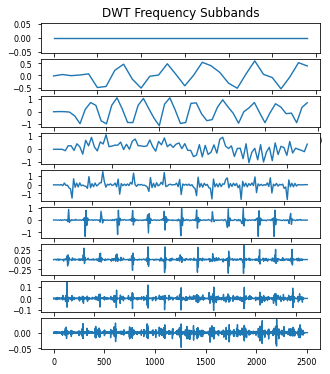

In [8]:
plt.figure(figsize=(5,6))

for i in range(0, len(coeffs)):
    if i == 1:
        plt.title('DWT Frequency Subbands', fontsize='large')
    plt.subplot(len(coeffs), 1, i+1)
    plt.plot(coeffs[i], label="Level " + str(i))

## Median Filter

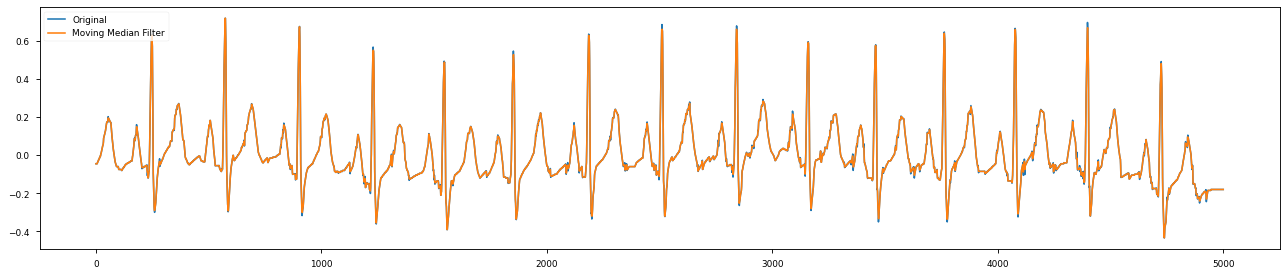

In [9]:
median_filter = signal.medfilt(lead_x)

plt.figure(figsize=(20, 4), dpi=80)
plt.plot(lead_x, label="Original")
plt.plot(median_filter, label="Moving Median Filter")
plt.legend(loc="upper left")